In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.flush_and_unmount()

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/Project/'

# **Part One**

> **Project Objective:** To create a classifier that predicts multiple features of the author of a given text.

### 1. Importing and analyzing the data set.

In [589]:
# Import required libraries

import pandas as pd
import copy
import seaborn as sns   
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")
sns.set(color_codes=True)
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [590]:
blog_text1 = pd.read_csv('/content/gdrive/MyDrive/Project/blogtext.csv')
blog_text1.shape

(681284, 7)

In [591]:
blog_text1.tail()

,id,gender,age,topic,sign,date,text
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ..."
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i..."
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin..."
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as..."
681283,1713845,male,23,Student,Taurus,"01,July,2004","Hey everybody...and Susan, You might a..."


In [592]:
blog_text1.duplicated().sum()

4686

In [593]:
# removing all the duplicate rows from the data
blog_text1 = blog_text1[blog_text1.duplicated(keep='first') == False]
blog_text1.shape

(676598, 7)

In [594]:
#Taking as sample of 5000 since the session is crashing later
blog_text = blog_text1[0:5000].copy()

In [595]:
blog_text.tail()

,id,gender,age,topic,sign,date,text
5009,1103575,female,17,indUnk,Scorpio,"23,August,2003",Yesterday was a very very long day... a...
5010,1103575,female,17,indUnk,Scorpio,"22,August,2003",From the Pratt Institute of Art book I ...
5011,1103575,female,17,indUnk,Scorpio,"21,August,2003","ugh I had forgotten, You don 't know..."
5012,1103575,female,17,indUnk,Scorpio,"21,August,2003",Disorder Rating urlLin...
5013,1103575,female,17,indUnk,Scorpio,"21,August,2003",'so long sweet summer' {I think... it m...


In [596]:
blog_text.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

In [597]:
blog_text.shape

(5000, 7)

In [598]:
blog_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 5013
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5000 non-null   int64 
 1   gender  5000 non-null   object
 2   age     5000 non-null   int64 
 3   topic   5000 non-null   object
 4   sign    5000 non-null   object
 5   date    5000 non-null   object
 6   text    5000 non-null   object
dtypes: int64(2), object(5)
memory usage: 312.5+ KB


In [599]:
blog_text.drop(['id','date'],axis= 1,inplace = True)

In [600]:
blog_text.head()

,gender,age,topic,sign,text
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,..."
1,male,15,Student,Leo,These are the team members: Drewe...
2,male,15,Student,Leo,In het kader van kernfusie op aarde...
3,male,15,Student,Leo,testing!!! testing!!!
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...


In [601]:
blog_text.describe()

,age
count,5000.000000
mean,29.516400
std,7.777855
min,14.000000
25%,24.000000
50%,35.000000
75%,35.000000
max,46.000000


In [602]:
blog_text.isna().sum()

gender    0
age       0
topic     0
sign      0
text      0
dtype: int64

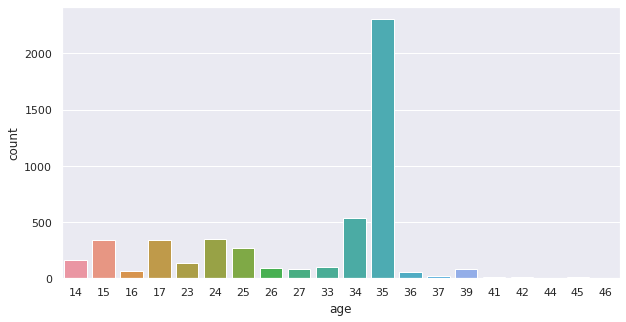

In [603]:
plt.figure(figsize= (10,5))
sns.countplot(x = 'age', data = blog_text)
plt.show()

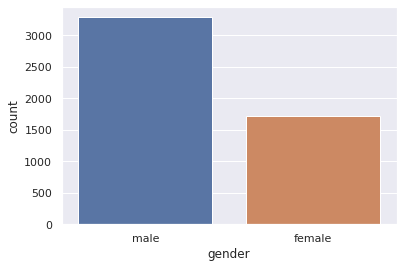

In [604]:
sns.countplot(x = 'gender', data = blog_text)
plt.show()

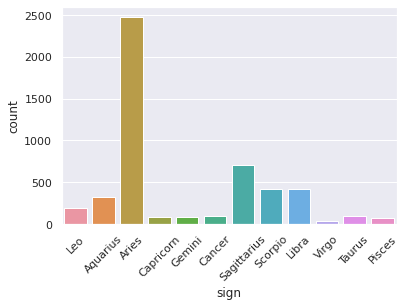

In [605]:
sns.countplot(x = 'sign', data = blog_text)
plt.xticks(rotation=45)
plt.show()

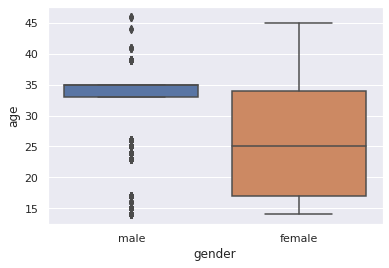

In [606]:
sns.boxplot(x = 'gender', y = 'age', data=blog_text)

In [607]:
age_groups = pd.cut(blog_text['age'], bins=[13, 17, 27, 47])
blog_text.groupby(age_groups)['gender'].count()

age
(13, 17]     916
(17, 27]     939
(27, 47]    3145
Name: gender, dtype: int64

In [608]:
pd.crosstab(age_groups, blog_text['gender'])

gender,female,male
age,,
"(13, 17]",549,367
"(17, 27]",485,454
"(27, 47]",680,2465


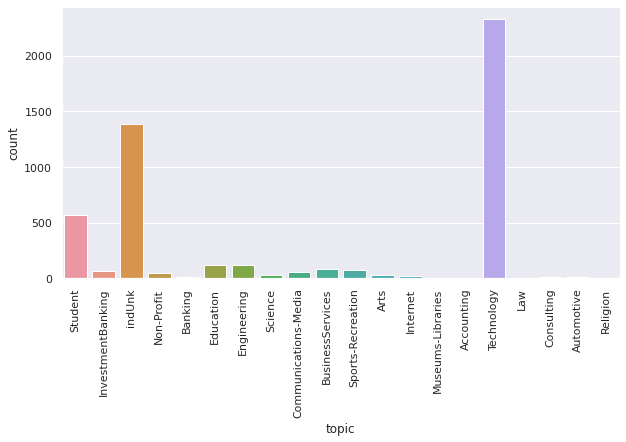

In [609]:
plt.figure(figsize= (10,5))
sns.countplot(x = 'topic', data = blog_text)
plt.xticks(rotation=90)
plt.show()

In [610]:
blog_text['text'][954]

"              urlLink    Dennis Frentsos and Erika Shay, a 'once engaged' couple from New York. Dennis is a 27-year-old mortgage broker from West Nyack while Erika is a 25-year-old wedding planner from Piermont. According to CBS, Dennis broke off the engagement after Erika went tandem skydiving naked with her instructor. No word on whether any peanut butter or chocolate was involved.  This was actually my favourite team to win. Sadly, they are eliminted cause of Dennis' nice guy attitude. Erika is so bloody stupid to lose herself a guy like this!         "

In [611]:
blog_text['text'][44]

"             Koreans have an interesting saying when referring to guys like me: 기러기아빠 ( urlLink gi-reo-gi  a-ppa, wild goose dad).  Whenever I told Koreans that I was here and my wife and kids are in Vancouver they would call me this, and now I know why.  My boss explained it to me quite well (although he called the bird a  urlLink seagull , as many Koreans do).  It goes like this: a goose flies very high in the sky (so does a vulture, but I guess that's not as poetic, nor as flattering) and has very good eyesight.  Therefore, it can see things waaaay in the distance--which is good, because that's where a 기러기아빠's family is...across the ocean.  It is used for Koreans who go abroad to work, as many do in the Middle East on the many Korean-lead construction projects there, for the many families that have the wife and kids in a foreign place (especially Canada, especially Vancouver...there are so many there) and the dad stays in Seoul, and for guys like me who come to work but whose wife 

### 2. Pre-processing the data

> *   Data cleansing by removing unwanted characters, spaces, stop words etc. Converting text to lowercase.
*   Target/label merger and transformation
*   Train and test split
*   Vectorisation, etc.







In [612]:
pattern = "[^\w\s]+"
blog_text.text = blog_text.text.apply(lambda s : re.sub(pattern," ",s))
pattern = "[^A-Za-z0-9]+"
blog_text.text = blog_text.text.apply(lambda s : re.sub(pattern," ",s))

In [613]:
# replace more than 1 space with 1 space
blog_text['text']= blog_text['text'].str.replace(r"\s\s+",' ') 
# delete beginning and trailing spaces
blog_text['text']= blog_text['text'].str.strip()

In [614]:
# extracting the stopwords from nltk library
stopwords = set(stopwords.words('english'))
# displaying the stopwords
np.array(stopwords)

array({"that'll", 'through', 'further', 'do', 'here', 'above', 'll', 'were', 'am', 'when', 'she', 'but', 'hers', 'no', "shan't", 'a', 'now', "couldn't", 'doing', "she's", 'our', 'you', 'until', 'in', 'some', "won't", "doesn't", "needn't", 'only', 'own', 've', 'it', 'hadn', 'her', 'don', 'same', 'and', "mightn't", 'wasn', 'under', 'y', 'does', "you'll", "wasn't", 'their', 'itself', 'of', 'this', 'very', 'before', 'will', 'those', 'nor', "isn't", "you're", 'so', 're', 'any', 'too', "wouldn't", 's', 'weren', "weren't", 'mustn', 'whom', 'be', 'as', 'once', 'where', 'couldn', 'after', 'its', 'he', 'over', "haven't", 'there', 'isn', 'yourself', 'or', 'your', 'should', "didn't", 'again', 'we', 'his', 'all', 'below', 'while', 'wouldn', 'myself', 'these', 'doesn', 'hasn', 'been', 'then', 'not', 'didn', 'being', 'how', "mustn't", 'me', 'if', "hasn't", 'because', 'shan', "you've", 'which', "it's", 'they', 'them', 'most', 'yourselves', 'd', 'ourselves', "should've", 'each', "you'd", 'is', 'had', '

In [615]:
len(stopwords)

179

In [616]:
blog_text.text = blog_text.text.apply(lambda t: ' '.join([word.lower() for word in t.split() if word.lower() not in stopwords]))

In [617]:
blog_text['text'][954]

'urllink dennis frentsos erika shay engaged couple new york dennis 27 year old mortgage broker west nyack erika 25 year old wedding planner piermont according cbs dennis broke engagement erika went tandem skydiving naked instructor word whether peanut butter chocolate involved actually favourite team win sadly eliminted cause dennis nice guy attitude erika bloody stupid lose guy like'

In [618]:
blog_text['text'][44]

'koreans interesting saying referring guys like urllink gi reo gi ppa wild goose dad whenever told koreans wife kids vancouver would call know boss explained quite well although called bird urllink seagull many koreans goes like goose flies high sky vulture guess poetic flattering good eyesight therefore see things waaaay distance good family across ocean used koreans go abroad work many middle east many korean lead construction projects many families wife kids foreign place especially canada especially vancouver many dad stays seoul guys like come work whose wife likes vancouver soooo much bear live seoul put children torture living another part korea things make lot sense first seem clearer get whole story urllink majestic beautiful canada goose'

In [619]:
blog_text['text'] = blog_text['text'].str.lower()
blog_text['text'] = blog_text['text'].str.strip()

In [620]:
# Before combining check for any null values in the dataframe. Though we had dropped nan earlier.
blog_text[blog_text.isnull() == True].count()

gender    0
age       0
topic     0
sign      0
text      0
dtype: int64

In [621]:
blog_text['age'] = blog_text['age'].astype(str)

In [622]:
blog_text['labels'] = blog_text.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)

In [623]:
blog_text.head()

,gender,age,topic,sign,text,labels
0,male,15,Student,Leo,info found 100 pages 4 5 mb pdf files wait unt...,"[male, 15, Student, Leo]"
1,male,15,Student,Leo,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,male,15,Student,Leo,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,male,15,Student,Leo,testing testing,"[male, 15, Student, Leo]"
4,male,33,InvestmentBanking,Aquarius,thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"


In [624]:
#drop gender,age,topic & sign 
blog_text.drop(columns=['gender','age','topic','sign'], axis=1, inplace=True)

In [625]:
blog_text.columns

Index(['text', 'labels'], dtype='object')

In [626]:
blog_text.head()

,text,labels
0,info found 100 pages 4 5 mb pdf files wait unt...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoo toolbar capture urls popups means...,"[male, 33, InvestmentBanking, Aquarius]"


In [627]:
#Splitting train & test
X = blog_text['text']
y = blog_text['labels']

In [628]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 40)

In [629]:
print("Train set shape: ", X_train.shape)
print("Test set shape: ", X_test.shape)

Train set shape:  (3500,)
Test set shape:  (1500,)


In [630]:
#Target merging & transformation

label_counts=dict()

for labels in blog_text.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

In [631]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [632]:
y_train = binarizer.fit_transform(y_train)

In [633]:
y_test = binarizer.transform(y_test)

In [634]:
# Creating the vectorizer
vectorizer = CountVectorizer(min_df = 2,ngram_range = (1,2),stop_words = "english")

X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [635]:
print("Length of the vocabulary: ", len(vectorizer.vocabulary_))
print("Shape of the vector: ",X_train_vector.shape)
print("Type: ",type(X_train_vector))

Length of the vocabulary:  27287
Shape of the vector:  (3500, 27287)
Type:  <class 'scipy.sparse.csr.csr_matrix'>


In [636]:
print("Shape of the vector: ",X_test_vector.shape)
print("Type: ",type(X_test_vector ))

Shape of the vector:  (1500, 27287)
Type:  <class 'scipy.sparse.csr.csr_matrix'>


### 3. Designing, training, tuning and testing the best text classifier

In [637]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(),n_jobs=1)),])
LR_pipeline.fit(X_train_vector, y_train)
LR_pred = LR_pipeline.predict(X_test_vector)

In [638]:
SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(C=1.0, penalty='l1', dual=False, loss='squared_hinge'), n_jobs=-1)),])
SVC_pipeline.fit(X_train_vector, y_train)
SVC_pred = SVC_pipeline.predict(X_test_vector)

In [639]:
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(alpha=1.0), n_jobs=-1)),])
NB_pipeline.fit(X_train_vector, y_train)
NB_pred = NB_pipeline.predict(X_test_vector)

In [640]:
SGD_pipeline = Pipeline([('clf', OneVsRestClassifier(SGDClassifier(), n_jobs=-1)),])
SGD_pipeline.fit(X_train_vector, y_train)
SGD_pred = SGD_pipeline.predict(X_test_vector)

In [641]:
print("Accuracy score before tuning:\n============================\n")
print("LOGISTIC REGRESSION MODEL")
print("-------------------------")
print('Training Accuracy: {:.2f}%'.format(LR_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,LR_pred)*100))
print("\nLINEAR SVC MODEL")
print("----------------")
print('Training Accuracy: {:.2f}%'.format(SVC_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,SVC_pred)*100))
print("\nNAIVE BAYES MODEL")
print("-----------------")
print('Training Accuracy: {:.2f}%'.format(NB_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,NB_pred)*100))
print("\nSTOCHASTIC GRADIENT DESCENT MODEL")
print("---------------------------------")
print('Training Accuracy: {:.2f}%'.format(SGD_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,SGD_pred)*100))

Accuracy score before tuning:

LOGISTIC REGRESSION MODEL
-------------------------
Training Accuracy: 95.97%
Test Accuracy: 51.80%

LINEAR SVC MODEL
----------------
Training Accuracy: 99.17%
Test Accuracy: 49.20%

NAIVE BAYES MODEL
-----------------
Training Accuracy: 69.74%
Test Accuracy: 33.73%

STOCHASTIC GRADIENT DESCENT MODEL
---------------------------------
Training Accuracy: 96.63%
Test Accuracy: 48.87%


In [642]:
param_grid = [
    {'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [100, 10, 1, 0.01, 5],
    'estimator__solver':  ['newton-cg', 'lbfgs', 'liblinear', 'sag']}]

In [643]:
log_reg_clf = OneVsRestClassifier(LogisticRegression())

LR_Tuning = GridSearchCV(log_reg_clf, param_grid, scoring = 'accuracy', cv = 3, error_score = 0, verbose = 2, n_jobs = -1)

LR_Tuning.fit(X_train_vector, y_train)
print(LR_Tuning.best_estimator_)
print('Best Score: %s' % LR_Tuning.best_score_)
print('Best Hyperparameters: %s' % LR_Tuning.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  8.4min finished


OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
Best Score: 0.5228555134700549
Best Hyperparameters: {'estimator__C': 1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [644]:
param_grid = [
    {'estimator__penalty': ['l1', 'l2'],
    'estimator__loss': ['hinge', 'squared_hinge']
     }]

In [645]:
lsvc_clf = OneVsRestClassifier(LinearSVC())

SVC_Tuning = GridSearchCV(lsvc_clf, param_grid, scoring = 'accuracy', cv = 3, error_score = 0, verbose = 2, n_jobs = -1)

SVC_Tuning.fit(X_train_vector, y_train)
print(SVC_Tuning.best_estimator_)
print('Best Score: %s' % SVC_Tuning.best_score_)
print('Best Hyperparameters: %s' % SVC_Tuning.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.2s finished


OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)
Best Score: 0.4934270188914415
Best Hyperparameters: {'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2'}


In [646]:
param_grid = [
    {'estimator__alpha': np.linspace(0.5, 1.5, 6),
     'estimator__fit_prior': [True, False],
     }]

In [647]:
NB_clf = OneVsRestClassifier(MultinomialNB())
NB_Tuning = GridSearchCV(NB_clf, param_grid, scoring = 'accuracy', cv = 3, error_score = 0, verbose = 2, n_jobs = -1)

NB_Tuning.fit(X_train_vector, y_train)
print(NB_Tuning.best_estimator_)
print('Best Score: %s' % NB_Tuning.best_score_)
print('Best Hyperparameters: %s' % NB_Tuning.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.6s finished


OneVsRestClassifier(estimator=MultinomialNB(alpha=0.5, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)
Best Score: 0.4014344345624357
Best Hyperparameters: {'estimator__alpha': 0.5, 'estimator__fit_prior': True}


In [648]:
param_grid = [
    {'estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
     'estimator__penalty': ['l2', 'l1', 'elasticnet'],
     'estimator__alpha':  np.linspace(0.5, 1.5, 6)
     }]

In [649]:
SGD_clf = OneVsRestClassifier(SGDClassifier())

SGD_Tuning = GridSearchCV(SGD_clf, param_grid, scoring = 'accuracy', cv = 3, error_score = 0, verbose = 2, n_jobs = -1)

SGD_Tuning.fit(X_train_vector, y_train)
print(SGD_Tuning.best_estimator_)
print('Best Score: %s' % SGD_Tuning.best_score_)
print('Best Hyperparameters: %s' % SGD_Tuning.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.8min finished


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.5, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='modified_huber',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)
Best Score: 0.3948592487419669
Best Hyperparamet

In [650]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(C= 1, penalty= 'l2', solver= 'liblinear'),n_jobs=1)),])
LR_pipeline.fit(X_train_vector, y_train)
LR_pred = LR_pipeline.predict(X_test_vector)

In [651]:
SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(loss= 'squared_hinge', penalty= 'l2'), n_jobs=-1)),])
SVC_pipeline.fit(X_train_vector, y_train)
SVC_pred = SVC_pipeline.predict(X_test_vector)

In [652]:
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(alpha= 0.5, fit_prior= True), n_jobs=-1)),])
NB_pipeline.fit(X_train_vector, y_train)
NB_pred = NB_pipeline.predict(X_test_vector)

In [653]:
SGD_pipeline = Pipeline([('clf', OneVsRestClassifier(SGDClassifier(alpha= 0.5, loss= 'modified_huber', penalty= 'l2'), n_jobs=-1)),])
SGD_pipeline.fit(X_train_vector, y_train)
SGD_pred = SGD_pipeline.predict(X_test_vector)

In [654]:
print("Accuracy score after tuning:\n============================\n")
print("LOGISTIC REGRESSION MODEL")
print("-------------------------")
print('Training Accuracy: {:.2f}%'.format(LR_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,LR_pred)*100))
print("\nLINEAR SVC MODEL")
print("----------------")
print('Training Accuracy: {:.2f}%'.format(SVC_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,SVC_pred)*100))
print("\nNAIVE BAYES MODEL")
print("-----------------")
print('Training Accuracy: {:.2f}%'.format(NB_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,NB_pred)*100))
print("\nSTOCHASTIC GRADIENT DESCENT MODEL")
print("---------------------------------")
print('Training Accuracy: {:.2f}%'.format(SGD_pipeline.score(X_train_vector,y_train)*100))
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test,SGD_pred)*100))

Accuracy score after tuning:

LOGISTIC REGRESSION MODEL
-------------------------
Training Accuracy: 96.26%
Test Accuracy: 51.73%

LINEAR SVC MODEL
----------------
Training Accuracy: 99.63%
Test Accuracy: 48.40%

NAIVE BAYES MODEL
-----------------
Training Accuracy: 77.26%
Test Accuracy: 39.00%

STOCHASTIC GRADIENT DESCENT MODEL
---------------------------------
Training Accuracy: 48.31%
Test Accuracy: 41.20%


In [655]:
def model_metric(y_test, pred):

    F1_arr = []
    recall_arr = []
    precision_arr = []

    F1_arr.append(f1_score(y_test, pred, average='micro'))
    F1_arr.append(f1_score(y_test, pred, average='macro'))
    F1_arr.append(f1_score(y_test, pred, average='weighted'))
    F1_arr.append(f1_score(y_test, pred, average='samples'))

    recall_arr.append(recall_score(y_test, pred, average='micro'))
    recall_arr.append(recall_score(y_test, pred, average='macro'))
    recall_arr.append(recall_score(y_test, pred, average='weighted'))
    recall_arr.append(recall_score(y_test, pred, average='samples'))

    precision_arr.append(precision_score(y_test, pred, average='micro'))
    precision_arr.append(precision_score(y_test, pred, average='macro'))
    precision_arr.append(precision_score(y_test, pred, average='weighted'))
    precision_arr.append(precision_score(y_test, pred, average='samples'))

    show_plot(F1_arr,recall_arr,precision_arr)

    return 

In [656]:
def show_plot(F1_arr,recall_arr,precision_arr):
  
    avg_lst = ['Micro','Macro','Weighted','Samples']

    #Creating a graph of multiple bars
    ig, ax = plt.subplots(figsize=(10,8))

    n_groups = 4
    index = np.arange(n_groups)
    bar_width = 0.1
    opacity = .7
    f1_bar = ax.bar(index,  F1_arr, bar_width, alpha=opacity, color='Sienna', label='F1 Score')
    precision_bar = ax.bar(index + bar_width, precision_arr, bar_width, alpha=opacity, color='orangered', label='Precision Score')
    recall_bar = ax.bar(index + (bar_width*2), recall_arr, bar_width, alpha=opacity, color='red', label='Recall Score')
    ax.set_xlabel('Model Metrics',  fontsize = 13)
    ax.set_ylabel('Model Performance Measures',  fontsize = 13)
    ax.set_title('Comparison of Model Metric Averages',  fontsize = 15)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(avg_lst, fontsize = 12)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize = 10, loc = 'best')
    plt.show()

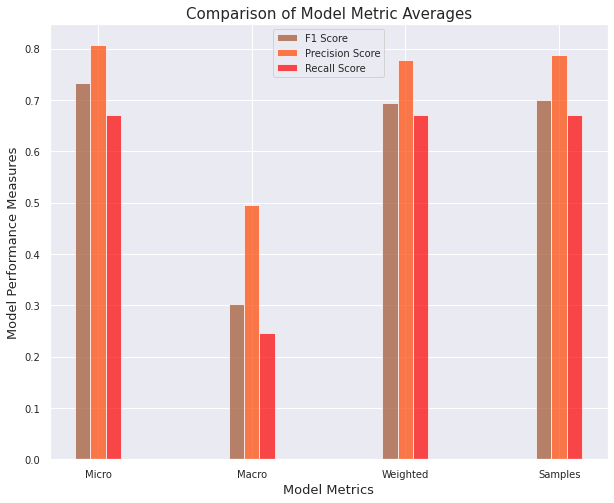

In [657]:
model_metric(y_test,LR_pred)

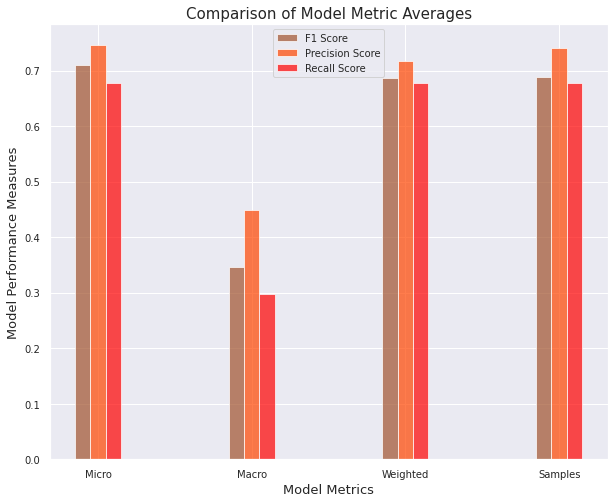

In [658]:
model_metric(y_test,SVC_pred)

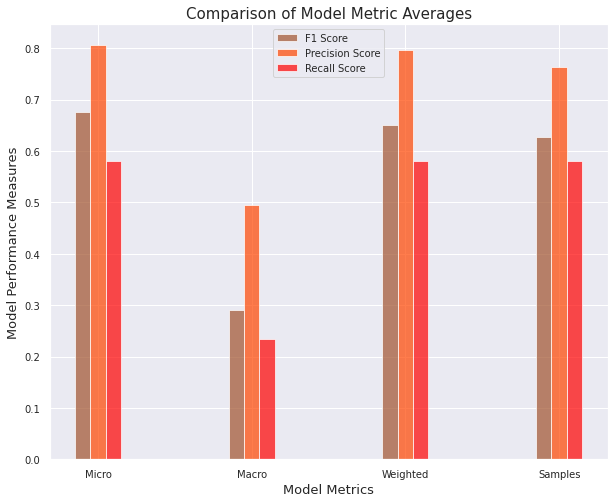

In [659]:
model_metric(y_test,NB_pred)

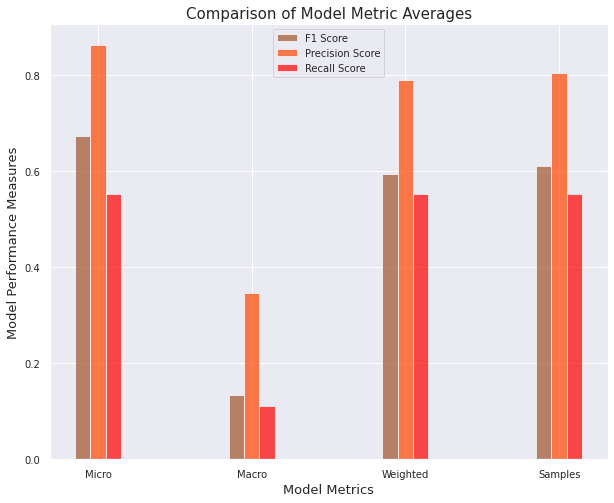

In [660]:
model_metric(y_test,SGD_pred)

### 4. Displaying and explaining the classification report

A Classification report shows the main classification metrics precision, recall and f1-score on a per-class basis. The metrics are calculated by using true and false positives, true and false negatives.

Precision – Accuracy of positive predictions.
Precision = TP/(TP + FP)

Recall: Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

F1 Score = 2 * (Recall * Precision) / (Recall + Precision)

A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

Here, Macro average is lower as dominating class has better predictions and so the micro average increase. This conclude that there is class imbalance. Out of the four trained models, we will select Logistic Regression has the best one and check predictions using this chosen model. Because the model metrics are comparitively better when compared. Also, the accuarcy score is higher than all the other models.
                       
                       precision    recall    f1-score
    micro avg          0.81         0.67      0.73
    macro avg          0.50         0.25      0.30
    weighted avg       0.78         0.67      0.69
    samples avg        0.79         0.67      0.70

As seen above, the accuracy for positive predictions is more than 0.5 for all the metric averages.
Also, the recall score is quite well as it is more than 0.6 across all the averages. 
The F1 Score takes both false positives and false negatives into account. In this case, we have F1 Score more than 0.7 across all the averages


In [661]:
print(classification_report(y_test,LR_pred))

              precision    recall  f1-score   support

           0       0.80      0.16      0.27        49
           1       0.73      0.35      0.47        95
           2       0.50      0.09      0.15        22
           3       0.90      0.25      0.39       104
           4       0.50      0.17      0.26        40
           5       0.71      0.32      0.44       115
           6       0.48      0.13      0.20        86
           7       1.00      0.05      0.10        38
           8       0.67      0.16      0.26        25
           9       0.88      0.48      0.62        31
          10       0.96      0.74      0.84       168
          11       0.81      0.91      0.86       677
          12       0.25      0.07      0.11        14
          13       0.00      0.00      0.00         6
          14       0.50      0.07      0.12        14
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.00    

### 5. Printing the true vs predicted labels for any 5 entries from the database

In [662]:
j=[]
for i in range(5):
    j.append(random.randint(500,len(prediction)))

for k in j:    
    print("\n========================================================")
    print("TRUE: ",binarizer.inverse_transform(y_test)[k])
    print("PREDICTION: ",binarizer.inverse_transform(LR_pred)[k])
    print("==========================================================")


TRUE:  ('35', 'Aries', 'Technology', 'male')
PREDICTION:  ('35', 'Aries', 'Technology', 'male')

TRUE:  ('15', 'Aries', 'female', 'indUnk')
PREDICTION:  ('15', 'Student', 'female', 'indUnk')

TRUE:  ('35', 'Aries', 'Technology', 'male')
PREDICTION:  ('35', '39', 'Aries', 'Technology', 'male')

TRUE:  ('17', 'Capricorn', 'Sports-Recreation', 'male')
PREDICTION:  ('17', 'Capricorn', 'Sports-Recreation', 'female')

TRUE:  ('34', 'Sagittarius', 'female', 'indUnk')
PREDICTION:  ('34', 'Sagittarius', 'female', 'indUnk')


# **Part Two**

> **Project Objective:**  To design a python based interactive semi - rule based chatbot which can do the following:

> 1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus. 
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.


In [561]:
import json 
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [562]:
pip install colorama

In [563]:
with open('/content/gdrive/MyDrive/Project/GL Bot.json') as f:
    final = json.load(f)

In [564]:
for intent in final['intents']:
    if intent['tag'] == 'Intro':
        intent['patterns'].extend(('Good Morning', 'Good evening', 'Good afternoon','please'))
    if intent['tag'] == 'Exit':
        intent['patterns'].extend(('Appreciated','Resolved','Solved','Goodbye','Good bye','bye','it was nice talking to you','Welcome'))
    if intent['tag'] == 'SL':
        intent['patterns'].extend(('Tuning','Model tuning'))
    if intent['tag'] == 'Profane':
        intent['patterns'].extend(('idiot','shitty','fuck'))
    if intent['tag'] == 'NN':
        intent['patterns'].extend(('What are neural network used for ?','3 components of neural network','NN','CNN','ANN'))
    if intent['tag'] == 'Bot':
        intent['patterns'].extend(('What are you','what is this','what'))
    if intent['tag'] == 'Ticket':
        intent['patterns'].extend(('Notes','Program manager','PM','Unable to login','Support Request','how to Raise a support request'))

In [565]:
with open('/content/gdrive/MyDrive/Project/Modified_jsonfile.json', 'w') as json_file:
    json.dump(final, json_file)

In [566]:
with open('/content/gdrive/MyDrive/Project/Modified_jsonfile.json') as f:
    data = pd.read_json(f)

In [567]:
labels = []
words=[]
documents = []
ignore_words = ['?', '!']

for intent in data['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in labels:  
            labels.append(intent['tag'])     
num_classes = len(labels)

In [568]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
labels = sorted(list(set(labels)))

In [569]:
# initializing training data
sentences = []
output_empty = [0] * len(labels)
for doc in documents:

    bag = []
    pattern_words = doc[0]

    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    output_row = list(output_empty)
    output_row[labels.index(doc[1])] = 1
    sentences.append([bag, output_row])

random.shuffle(sentences)
sentences = np.array(sentences)

# create train and test split
X = list(sentences[:,0])
y = list(sentences[:,1])

In [570]:
model = Sequential()
model.add(Dense(50, input_shape=(len(X[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                9350      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
Total params: 10,574
Trainable params: 10,574
Non-trainable params: 0
_________________________________________________________________


In [571]:
epochs = 250
history = model.fit(np.array(X), np.array(y), epochs=epochs, batch_size = 4, verbose = 1)

Epoch 1/250
40/40 [==============================] - 1s 3ms/step - loss: 2.0763 - accuracy: 0.1824
Epoch 2/250
40/40 [==============================] - 0s 4ms/step - loss: 2.0490 - accuracy: 0.1887
Epoch 3/250
40/40 [==============================] - 0s 3ms/step - loss: 2.0184 - accuracy: 0.2264
Epoch 4/250
40/40 [==============================] - 0s 3ms/step - loss: 1.9722 - accuracy: 0.2704
Epoch 5/250
40/40 [==============================] - 0s 4ms/step - loss: 1.9516 - accuracy: 0.2893
Epoch 6/250
40/40 [==============================] - 0s 3ms/step - loss: 1.8996 - accuracy: 0.2516
Epoch 7/250
40/40 [==============================] - 0s 4ms/step - loss: 1.8490 - accuracy: 0.2956
Epoch 8/250
40/40 [==============================] - 0s 3ms/step - loss: 1.7772 - accuracy: 0.3208
Epoch 9/250
40/40 [==============================] - 0s 4ms/step - loss: 1.7075 - accuracy: 0.4214
Epoch 10/250
40/40 [==============================] - 0s 3ms/step - loss: 1.6109 - accuracy: 0.4277
Epoch 11/

In [572]:
# to save the trained model
model.save("/content/gdrive/My Drive/Project/chat_model")

# to save the fitted tokenizer
with open('words.pickle', 'wb') as handle:
    pickle.dump(words, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('labels.pickle', 'wb') as ecn_file:
    pickle.dump(labels, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Project/chat_model/assets


In [573]:
def chatbot_response(inp):
    sentence_words = nltk.word_tokenize(inp)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                bag[i] = 1
    bag =  np.array(bag)

    result = model.predict(np.array([bag]))[0]
    ERROR_THRESHOLD = 0.25
    res = [[i,r] for i,r in enumerate(result) if r>ERROR_THRESHOLD]
    res.sort(key=lambda x: x[1], reverse=True)
    output_list = []
    for r in res:
    output_list.append({"intent": labels[r[0]], "probability": str(r[1])})

    tag = output_list[0]['intent']
    list_of_intents = data['intents']
    for i in list_of_intents:
    if(i['tag'] == tag):
        result = random.choice(i['responses'])
      # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))
    return result

In [663]:
import colorama 
colorama.init()
from colorama import Fore, Style, Back

with open('/content/gdrive/MyDrive/Project/Modified_jsonfile.json') as file:
    data = json.load(file)

def chat():

    model = keras.models.load_model('/content/gdrive/MyDrive/Project/chat_model')
    ignore_words = ['?', '!']

    with open('words.pickle', 'rb') as handle:
        words = pickle.load(handle)

    with open('labels.pickle', 'rb') as enc:
        labels = pickle.load(enc)

    print(Fore.LIGHTBLUE_EX + "\nChatBot: Hey There! How may I help you?" + Style.RESET_ALL, end="")
    # print("\nChatBot: Hey There! How may I help you?")

    while True:
        
        print(Fore.LIGHTBLUE_EX + "\nUser: " + Style.RESET_ALL, end="")
        # print("\nUser: ")

        inp = input()
        if inp.lower() == "quit":
            break

        sentence_words = nltk.word_tokenize(inp)
        sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

        bag = [0]*len(words)
        for s in sentence_words:
            for i,w in enumerate(words):
                if w == s:
                    bag[i] = 1
        bag =  np.array(bag)
      
        result = model.predict(np.array([bag]))[0]
        ERROR_THRESHOLD = 0.25
        res = [[i,r] for i,r in enumerate(result) if r>ERROR_THRESHOLD]
        res.sort(key=lambda x: x[1], reverse=True)
        output_list = []
        for r in res:
            output_list.append({"intent": labels[r[0]], "probability": str(r[1])})

        tag = output_list[0]['intent']
        list_of_intents = data['intents']
        for i in list_of_intents:
            if(i['tag'] == tag):
                result = random.choice(i['responses'])
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))
                # print("ChatBot:", np.random.choice(i['responses']))
print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
# print("Start messaging with the bot (type quit to stop)!")
chat()

Start messaging with the bot (type quit to stop)!

ChatBot: Hey There! How may I help you?
User: Hey Good afternoon
ChatBot: Hello! how can i help you ?

User: I need help with supervised learning ..i cannot understand anything
ChatBot: Link: Machine Learning wiki 

User: Also, need notes for NN
ChatBot: Link: Neural Nets wiki

User: How to raise support tickets ..i need extension
ChatBot: Tarnsferring the request to your PM

User: Oh..and where in Olympus can i raise ticket
ChatBot: Link: Olympus wiki

User: Oh okay..thank you!! Appreciated!!
ChatBot: I hope I was able to assist you, Good Bye

User: Quit


In [581]:
chatbot_response('Cant understand NLP')

'Link: Machine Learning wiki '

In [582]:
chatbot_response('I am unable to login')

'Tarnsferring the request to your PM'

In [583]:
chatbot_response('Help with Olympus')

'Link: Olympus wiki'

In [584]:
chatbot_response('Support request')

'Tarnsferring the request to your PM'